## Modeling for predicting critical outcome at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import os
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from helpers import PlotROCCurve
from dataset_path import output_path

path = output_path
output_path = os.path.join(path, "Figure3")

df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed = 0

2022-10-03 17:04:37.429906: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
random.seed(random_seed)
np.random.seed(random_seed)

In [3]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 

df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcomplaint,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,394512,10509415,NaN,39157213,2178-11-07 21:01:00,2178-11-07 21:26:00,45,M,2173,NaN,NaN,NaN,NaN,OTHER,NaN,NaN,NaN,2178,50,False,0 days 00:25:00,NaN,NaN,False,False,False,0,0,0,2178-11-09 10:37:00,1 days 13:11:00,True,0,0,0,0,0,0,0.42,NaN,1.55,36.722222,74.0,20.0,100.0,162.0,129.0,9.0,2.0,Abd pain,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.611111,72.0,16.0,100.0,180.0,123.0,0.0,3.0,9.0,140.000000,2,0,5,0,0,1
1,163920,19402485,27265022.0,35695207,2149-04-10 22:36:00,2149-04-11 00:47:05,55,M,2149,NaN,2149-04-11 00:46:00,2149-04-12 15:00:00,NaN,BLACK/AFRICAN AMERICAN,2149-04-10 22:36:00,2149-04-11 03:20:00,Other,2149,55,False,0 days 02:11:05,NaN,NaN,False,True,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,2.18,NaN,NaN,36.777778,90.0,20.0,97.0,131.0,77.0,0.0,2.0,Abd pain,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.555556,68.0,18.0,100.0,128.0,68.0,0.0,2.0,6.0,95.000000,1,4,3,0,0,1
2,235492,12126972,21011915.0,33586273,2110-03-31 10:59:00,2110-03-31 15:33:00,65,F,2110,NaN,2110-03-31 14:50:00,2110-04-02 13:40:00,NaN,WHITE,2110-03-31 10:59:00,2110-03-31 15:33:00,Other,2110,65,False,0 days 04:34:00,NaN,NaN,False,True,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,4.57,NaN,NaN,36.833333,90.0,18.0,94.0,122.0,71.0,0.0,1.0,"Dental pain, Facial swelling",...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.333333,84.0,22.0,93.0,138.0,80.0,4.0,4.0,3.0,88.000000,2,4,5,1,0,1
3,43991,17759885,NaN,31346320,2155-01-03 09:43:00,2155-01-03 09:54:00,63,F,2154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2155,64,False,0 days 00:11:00,NaN,NaN,False,False,False,0,1,1,2155-02-10 12:49:00,38 days 02:55:00,False,0,0,0,0,0,0,0.18,NaN,38.12,36.611111,98.0,14.0,99.0,136.0,71.0,2.0,3.0,Wound eval,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.222222,85.0,14.0,99.0,138.0,78.0,0.0,0.0,4.0,92.666667,2,4,3,1,1,0
4,291495,12197131,26028634.0,34998956,2123-07-30 11:41:00,2123-07-30 23:24:00,60,M,2123,NaN,2123-07-30 17:24:00,2123-08-08 13:02:00,NaN,OTHER,2123-07-30 11:41:00,2123-07-30 23:24:00,Medicaid,2123,60,False,0 days 11:43:00,NaN,NaN,False,True,False,0,0,0,2125-08-30 20:50:00,761 days 21:26:00,False,0,0,0,0,0,0,11.72,NaN,761.89,36.833333,82.0,16.0,100.0,125.0,85.0,3.0,3.0,LEFT NECK SWELLING,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.555556,75.0,17.0,100.0,144.0,80.0,0.0,7.0,8.0,98.333333,2,4,3,0,0,1


### 1. Task-specific filter: no task-specific exclusion needed

In [4]:
print('training size =', len(df_train), ', testing size =', len(df_test))

training size = 353150 , testing size = 88287


### 2. Variable Selection

In [5]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_critical"

In [6]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [7]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [8]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [9]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.06337811877073911 : 1


### 3.  Modeling script

In [10]:
# Containers for all results
result_list = []

Logistic Regression:


/home/jun/miniconda3/envs/mimic-ed/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 3.8674848079681396 seconds
AUC: 0.8635348865167564
AUPRC: 0.32078197121492086
Sensitivity: 0.7832618025751072
Specificity: 0.7849472709563377
Score thresold: 0.06491469027849527
2.5 97.5


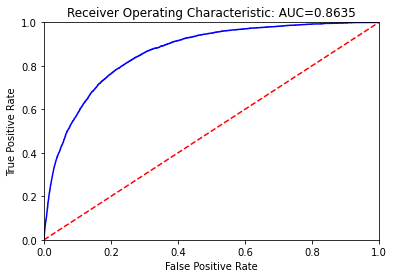

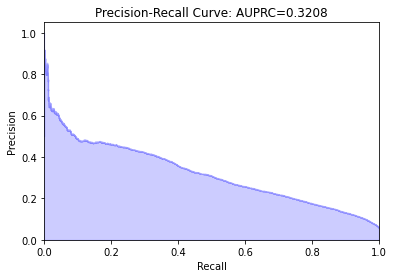

In [11]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
import pickle
with open('task2_logreg.pickle', 'wb') as model_dump:
    pickle.dump(logreg, model_dump)
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1], y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)

RandomForest:
Training time: 51.00395750999451 seconds
AUC: 0.874607197243009
AUPRC: 0.3802664418494741
Sensitivity: 0.8029652750682793
Specificity: 0.7921020670747105
Score thresold: 0.07796969696969698
2.5 97.5


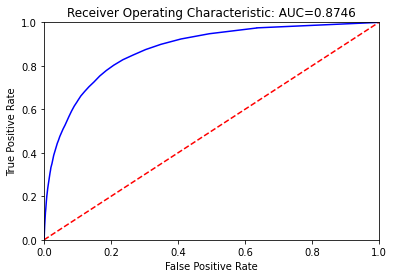

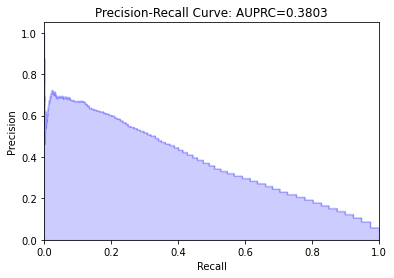

[0.09979615 0.01498479 0.00643844 0.01017414 0.01865609 0.00638709
 0.01011379 0.01699745 0.00314623 0.00653554 0.01216819 0.07656557
 0.09314993 0.05667479 0.05048244 0.09977734 0.0837901  0.0398227
 0.09208902 0.00579659 0.00633416 0.00394091 0.00144544 0.00215969
 0.00244767 0.00285685 0.00483899 0.00344936 0.00301059 0.00508465
 0.00569384 0.00506429 0.00508257 0.00290588 0.00739781 0.00267797
 0.00274681 0.00470398 0.00745412 0.00473181 0.00261075 0.00503688
 0.00540101 0.00292602 0.00373994 0.00119872 0.00713885 0.00475351
 0.00450349 0.00494024 0.00905785 0.00597194 0.00565694 0.00182604
 0.0055736  0.00560988 0.00477659 0.00686247 0.00229906 0.00450865
 0.00474527 0.00374296 0.00265095 0.00689459]


In [12]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 58.407652378082275 seconds
AUC: 0.8797685537218084
AUPRC: 0.38696328720995155
Sensitivity: 0.8094030433086227
Specificity: 0.7896008946501365
Score thresold: 0.06366472872287673
2.5 97.5


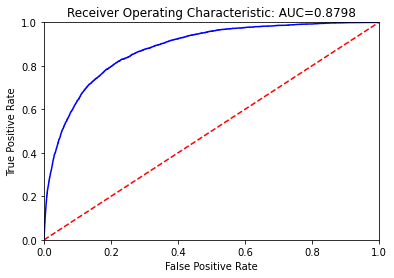

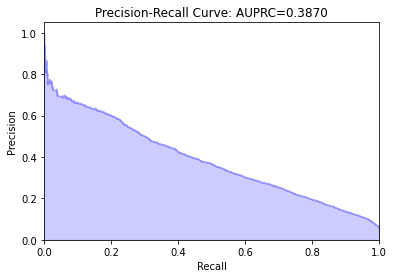

In [13]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [14]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [15]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('critical_triage_mlp')

2022-10-03 17:06:41.398880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 17:06:42.320822: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2022-10-03 17:06:42.321388: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22304 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


Epoch 1/20
  40/1766 [..............................] - ETA: 7s - loss: 0.2733 - accuracy: 0.9317 - auc: 0.6443 - auprc: 0.1113 - true_positives: 24.0000 - true_negatives: 7430.0000 - precision: 0.2243 - recall: 0.0493           

2022-10-03 17:06:44.233520: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1766/1766 [==============================] - 10s 5ms/step - loss: 0.1839 - accuracy: 0.9402 - auc: 0.8232 - auprc: 0.2778 - true_positives: 2183.0000 - true_negatives: 329851.0000 - precision: 0.4923 - recall: 0.1037
Epoch 2/20
1766/1766 [==============================] - 8s 5ms/step - loss: 0.1720 - accuracy: 0.9414 - auc: 0.8542 - auprc: 0.3264 - true_positives: 2925.0000 - true_negatives: 329514.0000 - precision: 0.5306 - recall: 0.1390
Epoch 3/20
1766/1766 [==============================] - 8s 5ms/step - loss: 0.1669 - accuracy: 0.9423 - auc: 0.8655 - auprc: 0.3491 - true_positives: 2990.0000 - true_negatives: 329783.0000 - precision: 0.5632 - recall: 0.1421
Epoch 4/20
1766/1766 [==============================] - 9s 5ms/step - loss: 0.1650 - accuracy: 0.9426 - auc: 0.8702 - auprc: 0.3550 - true_positives: 3050.0000 - true_negatives: 329814.0000 - precision: 0.5714 - recall: 0.1449
Epoch 5/20
1766/1766 [==============================] - 8s 5ms/step - loss: 0.1637 - accuracy: 0.9428 

MLP:
2759/2759 [==============================] - 3s 1ms/step
AUC: 0.8827838091686288
AUPRC: 0.38911948956815645
Sensitivity: 0.8125243854857589
Specificity: 0.7866788518656582
Score thresold: 0.045954738
2.5 97.5


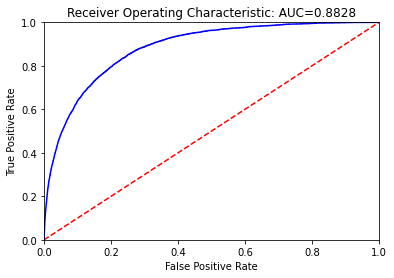

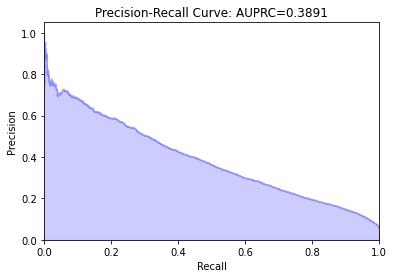

In [16]:
print("MLP:")
mlp = load_model('critical_triage_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [17]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


ESI
AUC: 0.8039655054643638
AUPRC: 0.1942196456343015
Sensitivity: 0.870074131876707
Specificity: 0.6401197676795614
Score thresold: -2.0
2.5 97.5


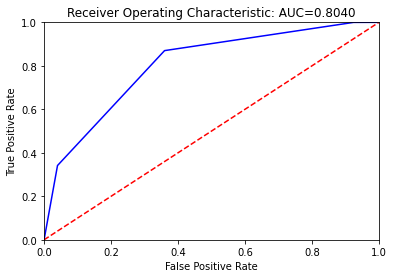

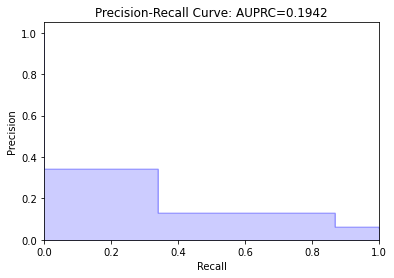

In [18]:
df_test["ESI"] = -df_test["triage_acuity"]
get_score_performance("ESI", random_seed=random_seed)

In [19]:
## input AutoScore result from csv (implemented by R, detail: https://github.com/nliulab/AutoScore)
AutoScore_pred = pd.read_csv((os.path.join(path, 'AutoScore_Crtical.csv')))
df_test["AutoScore"] = AutoScore_pred["pred_score"]

AutoScore
AUC: 0.8462702241626242
AUPRC: 0.27840073486535316
Sensitivity: 0.8047210300429185
Specificity: 0.7280455982972788
Score thresold: 66
2.5 97.5


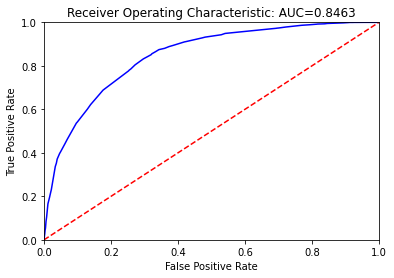

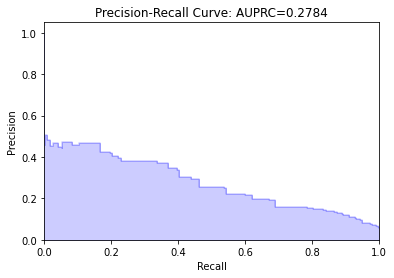

In [20]:
get_score_performance("AutoScore", random_seed=random_seed) 

score_NEWS
AUC: 0.6341903573953401
AUPRC: 0.14157240789712475
Sensitivity: 0.46390948107686303
Specificity: 0.7954810548213707
Score thresold: 2
2.5 97.5


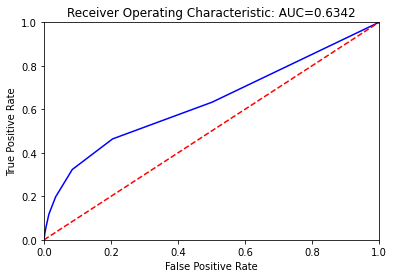

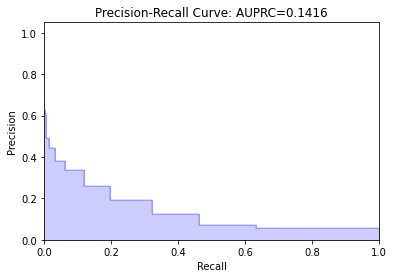

In [21]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS2
AUC: 0.6165137178284772
AUPRC: 0.12807667183072463
Sensitivity: 0.4104564962934062
Specificity: 0.8225490313969288
Score thresold: 2
2.5 97.5


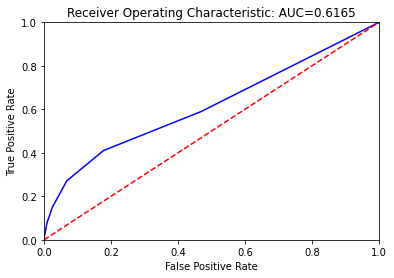

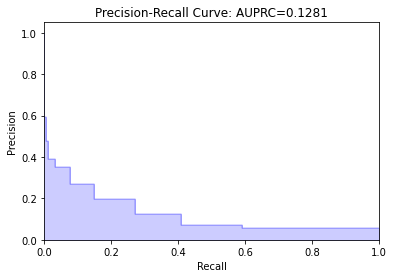

In [22]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_REMS
AUC: 0.6858237001110102
AUPRC: 0.10555264874976322
Sensitivity: 0.6808427623878268
Specificity: 0.6155649883960029
Score thresold: 5
2.5 97.5


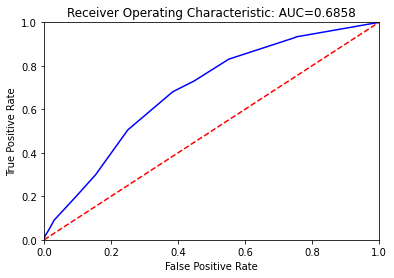

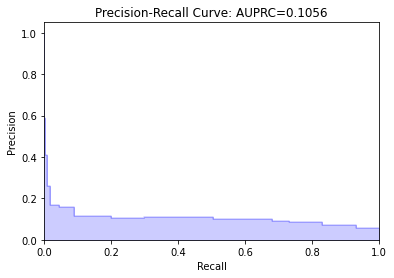

In [23]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.6136127819001566
AUPRC: 0.10350411545674533
Sensitivity: 0.43055013655872026
Specificity: 0.7698801120717644
Score thresold: 2
2.5 97.5


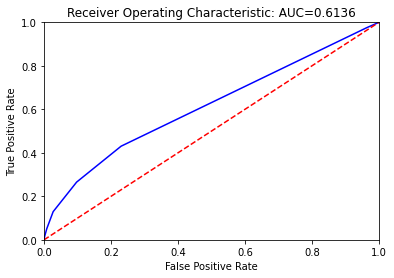

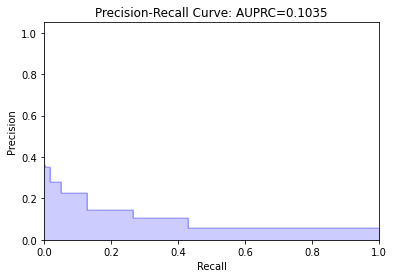

In [24]:
get_score_performance("score_MEWS", random_seed=random_seed)

score_CART
AUC: 0.7074561210922072
AUPRC: 0.14183887641580045
Sensitivity: 0.5901287553648069
Specificity: 0.7307271437332403
Score thresold: 6
2.5 97.5


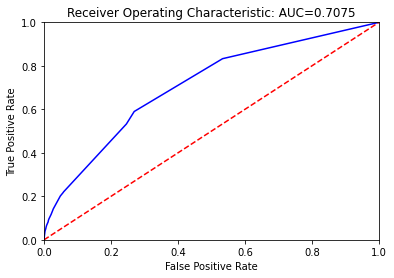

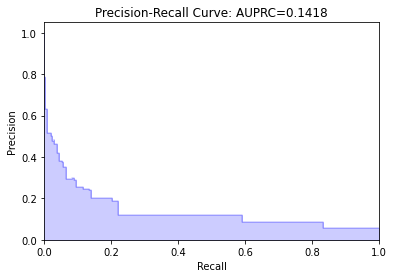

In [25]:
get_score_performance("score_CART", random_seed=random_seed)

In [26]:
import tensorflow.keras as keras
from tensorflow.keras import optimizers, metrics, layers, Model
from embedding import *

In [27]:
print("Med2Vec:")
version = 'v10'
batch_size=200
vocabulary = vocabulary_map[version]
df_icd_encode = pd.read_csv(os.path.join(path, 'icd_list_dataset_'+version+'.csv'))
df_train_embed = pd.merge(df_train, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')
df_test_embed = pd.merge(df_test, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')

train_gen, test_gen = setup_embedding_data(df_train_embed, df_test_embed, X_train, y_train, X_test, y_test, batch_size)


Med2Vec:


Model: "embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 icd_input (InputLayer)         [(None, 7930)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 7930, 1024)   8121344     ['icd_input[0][0]']              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None, 1024)        0           ['embedding[0][0]']              
 )                                                                                                
                                                                                                  
 dense_3 (Dense)                (None, 256)          262400      ['tf.math.reduce_su

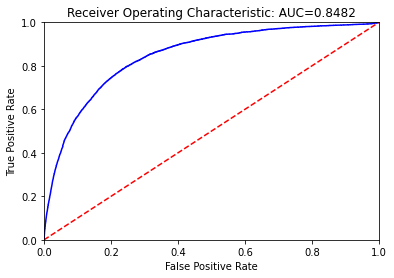

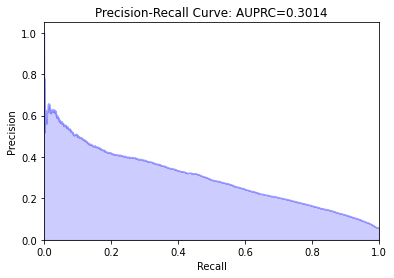

In [28]:
# To train from scratch, set load_model to None
load_model = None#"embedding_critical_"+version 
save_model = "embedding_critical_"+version

if load_model:
        model = keras.models.load_model(load_model)
else:
        model = create_embedding_model(vocabulary, len(variable))
model.summary()
model.compile(loss='binary_crossentropy', 
        optimizer=optimizers.Adam(learning_rate=0.001, decay=0.01), 
        metrics=['accuracy', 'AUC', {'aucpr': metrics.AUC(name='aucpr', curve='PR')}, 
                    'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
runtime = 1063.299 # to be updated
if not load_model:
        start = time.time()
        model.fit(train_gen, epochs=100, class_weight={1:ratio, 0:1}, verbose=0)
        runtime = time.time()-start
        print('Training time:', runtime, 'seconds')
if save_model:
        keras.models.save_model(model, save_model)
output = model.predict(test_gen)
result = PlotROCCurve(output,y_test, ci=confidence_interval, random_seed=random_seed)

results = ["Med2Vec"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 4. Performance output

In [29]:
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 
                                               'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 
                                               'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 
                                               'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_critical_triage.csv'), index=False)

result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task2.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.065,0.864 (0.859-0.868),0.321 (0.308-0.336),0.783 (0.773-0.809),0.785 (0.756-0.793),3.867
1,RF,0.078,0.875 (0.87-0.879),0.38 (0.37-0.393),0.803 (0.794-0.81),0.792 (0.791-0.795),51.004
2,GB,0.064,0.88 (0.876-0.884),0.387 (0.373-0.405),0.809 (0.79-0.821),0.79 (0.783-0.81),58.408
3,MLP,0.046,0.883 (0.879-0.888),0.389 (0.377-0.407),0.813 (0.805-0.829),0.787 (0.772-0.794),171.311
4,ESI,-2.000,0.804 (0.801-0.809),0.194 (0.187-0.205),0.87 (0.863-0.875),0.64 (0.637-0.643),0.000
5,AutoScore,66.000,0.846 (0.842-0.851),0.278 (0.267-0.293),0.805 (0.785-0.81),0.728 (0.726-0.747),0.000
6,score_NEWS,2.000,0.634 (0.627-0.641),0.142 (0.132-0.145),0.464 (0.453-0.472),0.795 (0.793-0.798),0.000
7,score_NEWS2,2.000,0.617 (0.608-0.624),0.128 (0.122-0.132),0.41 (0.398-0.585),0.823 (0.532-0.824),0.000
8,score_REMS,5.000,0.686 (0.679-0.691),0.106 (0.102-0.111),0.681 (0.668-0.687),0.616 (0.613-0.619),0.000
9,score_MEWS,2.000,0.614 (0.607-0.618),0.104 (0.1-0.109),0.431 (0.418-0.439),0.77 (0.768-0.772),0.000


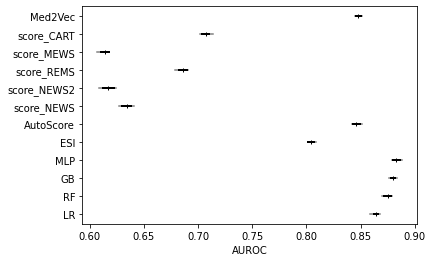

In [30]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC", 
                         my_file = 'AUROC_critical.eps', my_path = output_path) 

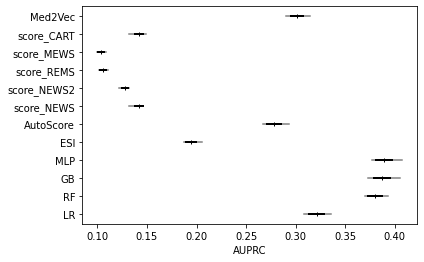

In [31]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC", 
                         my_file = 'AUPRC_critical.eps', my_path = output_path)

In [32]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_critical_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
0,age,0.099796
15,triage_sbp,0.099777
12,triage_heartrate,0.093150
18,triage_acuity,0.092089
16,triage_dbp,0.083790
11,triage_temperature,0.076566
13,triage_resprate,0.056675
14,triage_o2sat,0.050482
17,triage_pain,0.039823
4,n_ed_365d,0.018656
